In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00


In [14]:
# 필요한 패키지 설치
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [15]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
#from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [16]:
df = pd.read_csv("walmart_cleaned.csv")

# 데이터 샘플 확인
df.head()

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


In [17]:
df

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,423281,45,2012-10-26,0,13.0,26240.14,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421566,423282,45,2012-10-26,0,16.0,2660.02,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421567,423283,45,2012-10-26,0,32.0,4131.54,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421568,423284,45,2012-10-26,0,83.0,717.82,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


In [18]:
# 주별 집계 데이터 테이블을 만들기!

df['Date']= pd.to_datetime(df['Date'])
#날짜 정렬하기
df = df.sort_values(by='Date')

#연도 컬럼 빼기
df['year'] = df['Date'].dt.year # dt. 방식으로 시계열에서 연도, 월, 일 정보 추출 가능

# 집계 컬럼만들기
# 딕셔너리 형태로 집계 -> 동일 날짜의 데이터를 다양한 방식으로 재구성해서 표현

def func(df):
    df_sum={}
    df_sum['Weekly_Sales'] = df['Weekly_Sales'].sum()
    df_sum['Temperature'] = df['Temperature'].mean()
    df_sum['Fuel_Price'] = df['Fuel_Price'].mean()
    df_sum['IsHoliday'] = df['IsHoliday'].max()
    df_sum['CPI'] = df['CPI'].mean()
    df_sum['Unemployment'] = df['Unemployment'].mean()
    return pd.Series(df_sum, index=['Weekly_Sales','Temperature','Fuel_Price','IsHoliday','CPI','Unemployment'])


df_agg = df.groupby(['year','Date']).apply(func).reset_index()

df_agg

,year,Date,Weekly_Sales,Temperature,Fuel_Price,IsHoliday,CPI,Unemployment
0,2010,2010-02-05,49750740.50,33.277942,2.717869,0.0,167.398405,8.576731
1,2010,2010-02-12,48336677.63,33.361810,2.696102,1.0,167.384138,8.567309
2,2010,2010-02-19,48276993.78,37.038310,2.673666,0.0,167.338966,8.576351
3,2010,2010-02-26,43968571.13,38.629563,2.685642,0.0,167.691019,8.561375
4,2010,2010-03-05,46871470.30,42.373998,2.731816,0.0,167.727351,8.572689
...,...,...,...,...,...,...,...,...
138,2012,2012-09-28,43734899.40,68.151759,3.858245,0.0,175.919639,7.225855
139,2012,2012-10-05,47566639.31,65.456811,3.848435,0.0,175.998254,6.942141
140,2012,2012-10-12,46128514.25,57.687284,3.897425,0.0,176.123786,6.952682
141,2012,2012-10-19,45122410.57,60.152756,3.878413,0.0,176.295499,6.948928


Text(0.5, 1.0, 'Temperature')

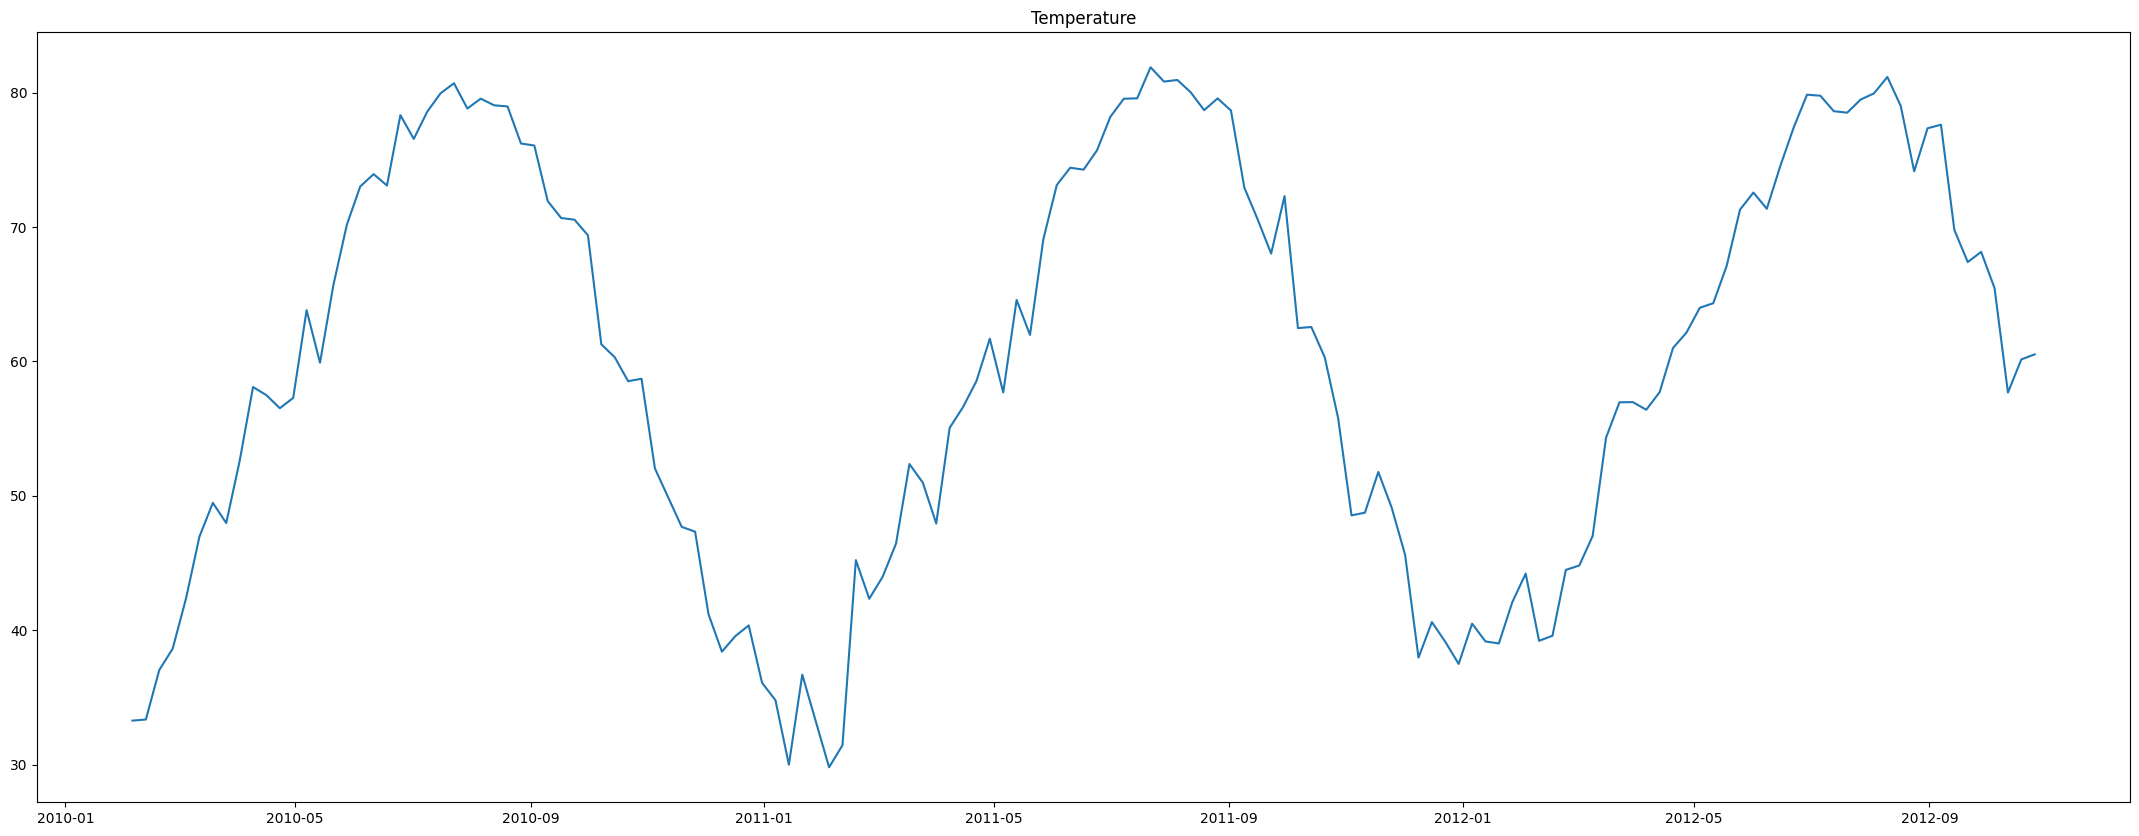

In [19]:
# 전체 예측할 변수의 추세나 변동 확인하자!

plt.figure(figsize=(27,10))
plt.plot(df_agg.Date, df_agg.Temperature)
plt.title('Temperature')

In [20]:
#decomp 간단하게 분해하기!
timeseries_decomp = df_agg.loc[:, ['Date','Temperature']]
timeseries_decomp.index = timeseries_decomp.Date
ts_decomp = timeseries_decomp.drop('Date',axis=1)
#전처리 과정
ts_decomp
#분해해서 날짜와 기온 데이터만 추출한 뒤, 시간 데이터를 인덱스로 지정함

,Temperature
Date,
2010-02-05,33.277942
2010-02-12,33.361810
2010-02-19,37.038310
2010-02-26,38.629563
2010-03-05,42.373998
...,...
2012-09-28,68.151759
2012-10-05,65.456811
2012-10-12,57.687284


<Figure size 640x480 with 0 Axes>

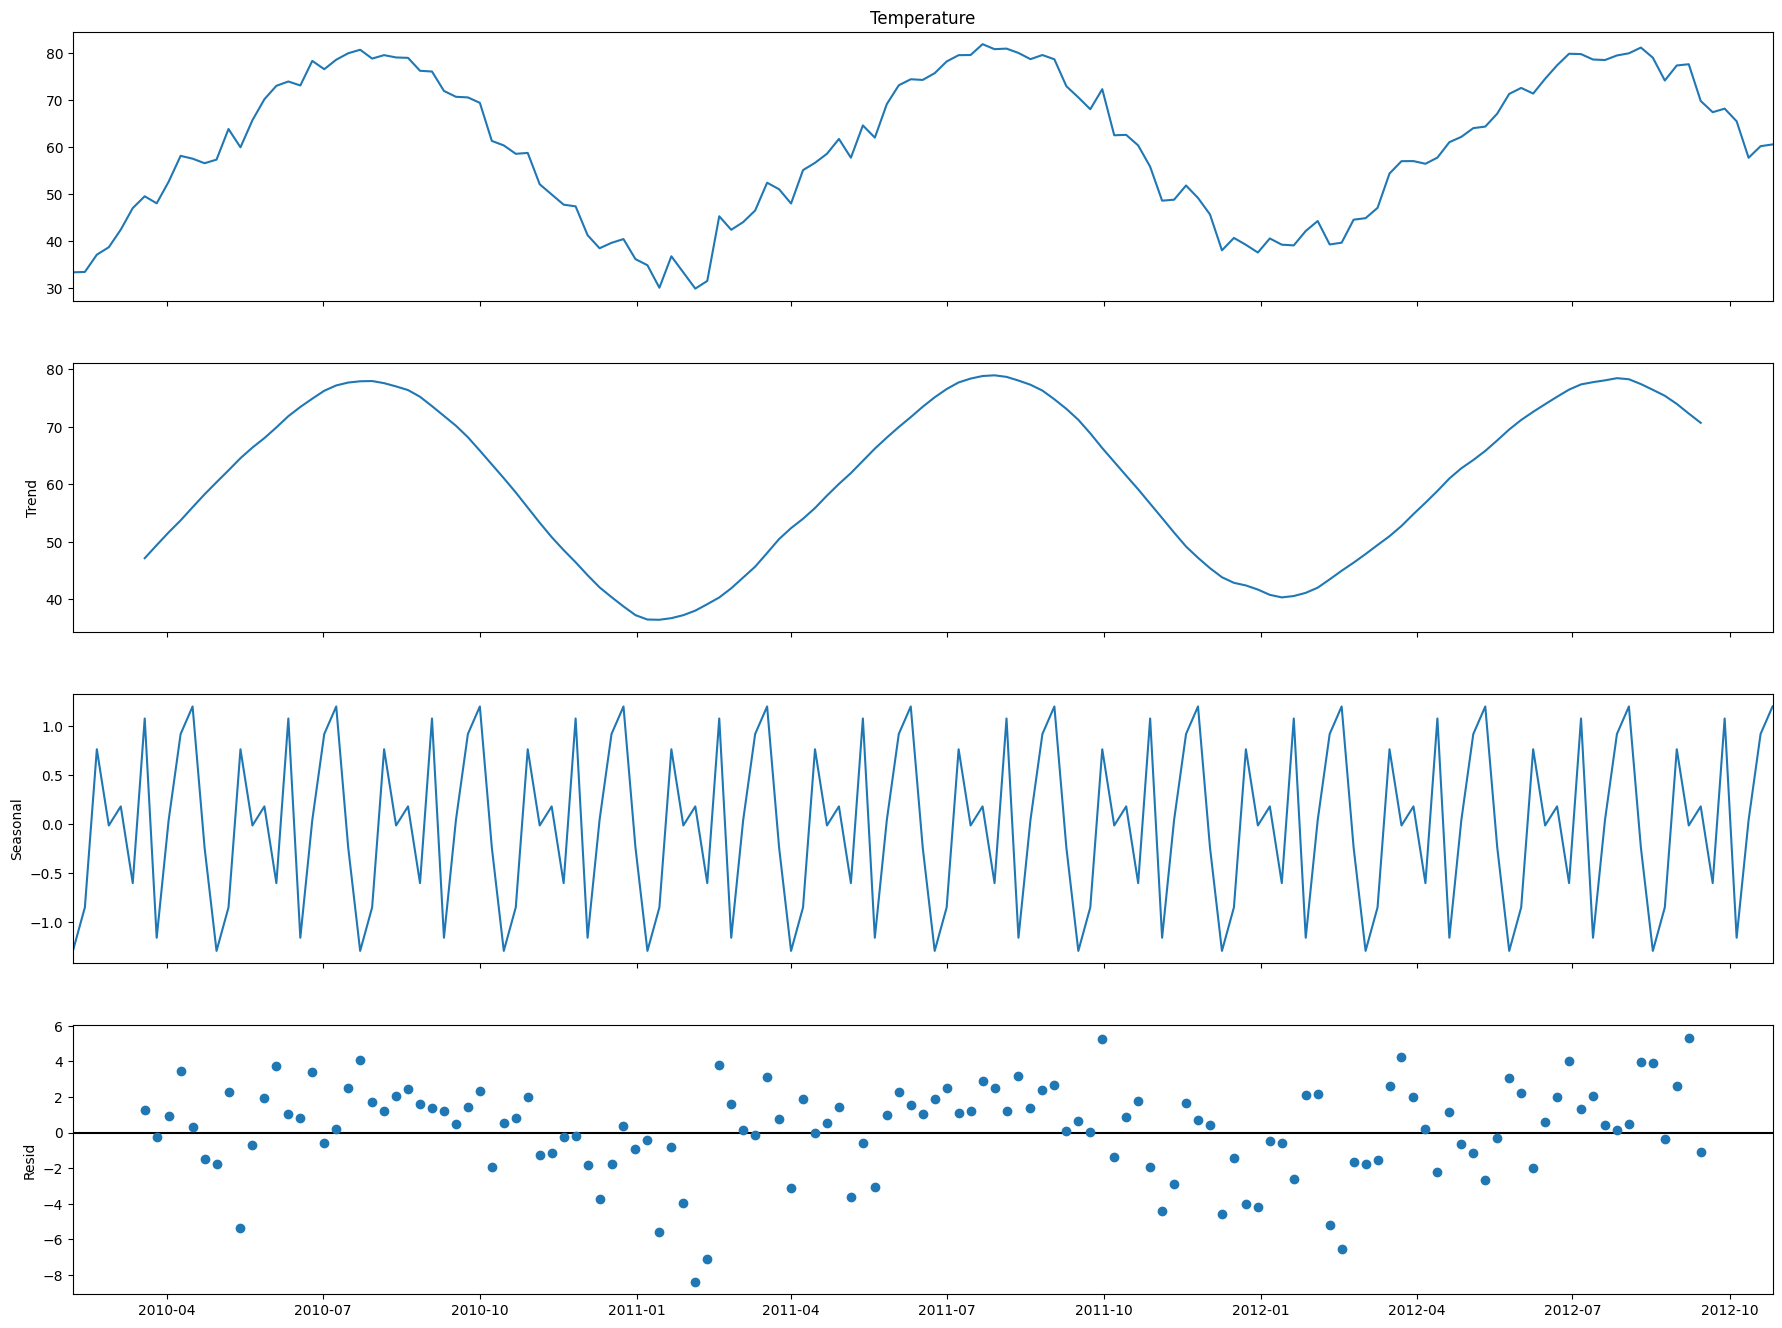

In [21]:
#시계열로 분해하기
# seasonal_decompose( 패턴을 확인, 월별 12 주별, 4 일별은 7 지정해서 여러가지로 패턴을 볼 수 있다)

decomp = seasonal_decompose(ts_decomp['Temperature'], model= 'additive', period =12) #1년 간의 기온 변화를 월별로 분리해서 관찰

fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(20,15)
plt.show()

## ACF, PACF 함수 그래프 그리기!

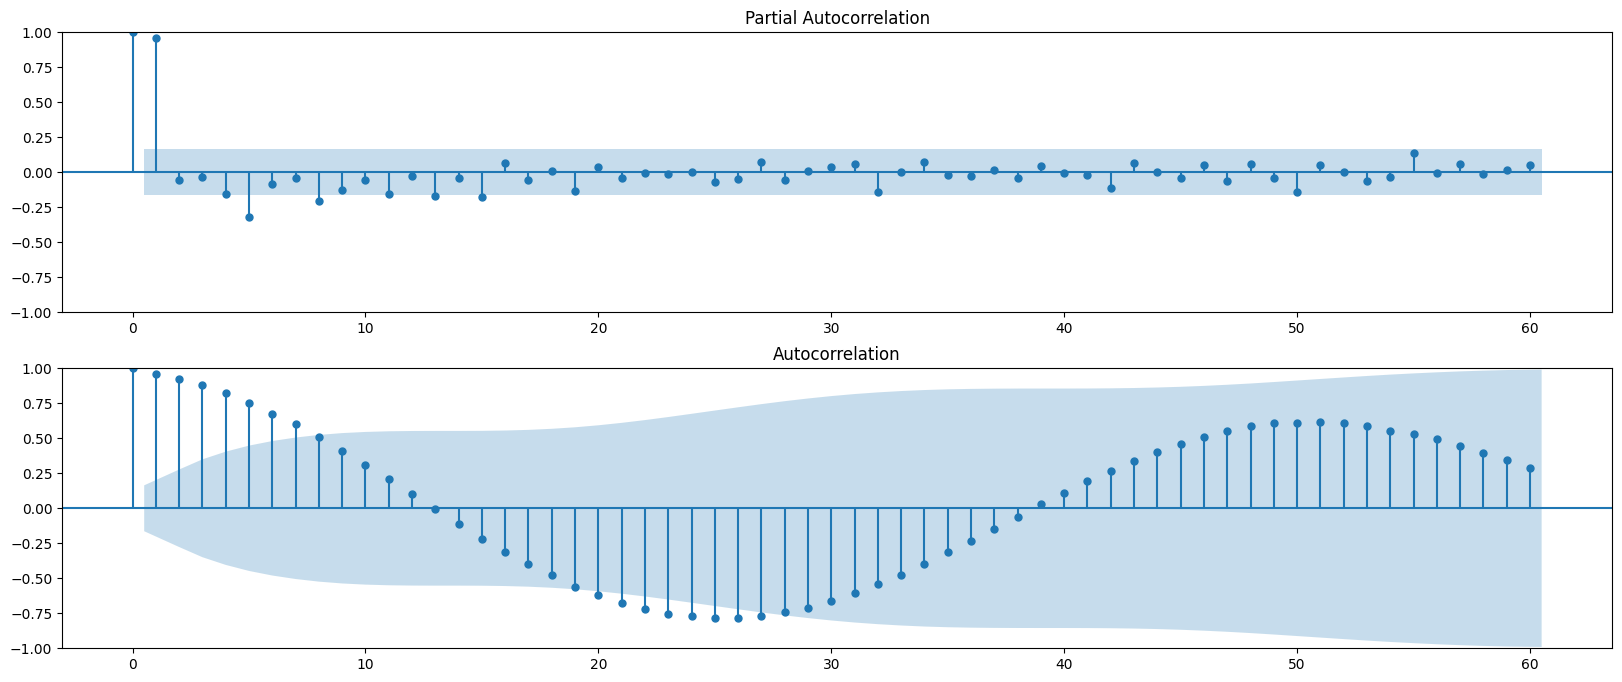

In [22]:
fig =plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(ts_decomp, lags=60, ax=ax1)

ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(ts_decomp, lags=60, ax=ax2)


- 1주전의 영향이 있는 것으로 보인다.
- 연말에 그래프에 나온 것처럼 영향력이 있다는 것을 확인!

# 1. 회귀분석을 통한 예측
- 회귀분석을 통한 다항회귀 개념의 예측이기 때문에 변수를 여러 개 사용 가능하다!

In [24]:
df_agg['Temperature_1m']= df_agg['Temperature'].shift(1)
df_agg['Temperature_2m']=df_agg['Temperature'].shift(2)
df_agg['Temperature_3m']=df_agg['Temperature'].shift(3)
df_agg['Temperature_4m']=df_agg['Temperature'].shift(4)

df_agg['Temperature_12m']=df_agg['Temperature'].shift(12)


#모델의 학습을 하기 위해서 데이터 기간을 설정!

df_agg[df_agg['Date'].isin(pd.date_range('2011-02-05', '2012-10-26'))]

# x와 y 독립변수와 종속변수 분리

df_x = df_agg.drop(['year','Date','Temperature'],axis=1)
df_y = df_agg[['Temperature']]

# 테스트 데이터 트레인데이터 분리
df_x =df_x.fillna(0) # na값들을 0으로 인식하여 문제 발생!
x_train, x_test, y_train, y_test = train_test_split(
df_x, df_y, test_size=0.6, random_state=1)
# 시계열이지만 -> 쉐어를 진행했다. 회귀분석으로 진행을 하다보니!
# year, date 날렸다. 그냥 회귀분석의 개념으로 시계열 값은 날리고 예측을 진행


In [25]:
#다중 회귀 모델 학습
mreg = LinearRegression(fit_intercept=True)
mreg.fit(x_train, y_train)

# 테스트셋 모델 적용

y_predict = mreg.predict(x_test)

#모델 성능 확인

print('학습 데이터 R-Squarue {:.5f}'.format(mreg.score(x_train, y_train)))
print('테스트 데이터 R-Squarue {:.5f}'.format(mreg.score(x_test, y_test)))

학습 데이터 R-Squarue 0.92951
테스트 데이터 R-Squarue 0.93623


- na값을 0으로 다 받아들여서 -> 0으로 인식해서 가중치 자체가 잘못잡혀서 이런식으로 잘못된 결과가 나온 것 같다.
- 다중회귀 진행하는데 스케일링도 하지 않고 na값 자체를 그냥 0으로 넣어서 문제

** 복습과제에선 Temperature data를 통해 진행하였고, weekly sales에 비해 데이터
값이 작기 때문에 비교적 높은 정확도가 도출되었다.

In [26]:
#모델 상세 확인

ols_m = sm.OLS(y_train, sm.add_constant(x_train)).fit()
ols_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     60.65
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           4.27e-23
Time:                        04:36:05   Log-Likelihood:                -164.75
No. Observations:                  57   AIC:                             351.5
Df Residuals:                      46   BIC:                             374.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -384.9740    310.410     -1.240      0.221   -1009.797     239.848
Weekly_Sales    -4.053e-09    2.6e-07     -0.016      0.988   -5.28e-07     5.2e-07
Fuel_Price         -1.8874      3.676     -0.513      0.610      -9.287       5.512
IsHoliday          -1.7689      3.159     -0.560      0.578      -8.128       4.591
CPI                 1.8939      1.529      1.239      0.222      -1.183       4.971
Unemployment       10.2718      7.949      1.292      0.203      -5.728      26.272
Temperature_1m      0.5560      0.164      3.387      0.001       0.226       0.886
Temperature_2m     -0.0161      0.254     -0.064      0.950      -0.527       0.495
Temperature_3m      0.0919      0.242      0.380      0.706      -0.395       0.579
Temperature_4m      0.3785      0.152      2.487      0.017       0.072       0.685
Temperature_12m    -0.2477      0.057     -4.349      0.000      -0.362      -0.133
==============================================================================
Omnibus:                       17.230   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.672
Skew:                           0.646   Prob(JB):                     3.65e-12
Kurtosis:                       7.529   Cond. No.                     2.24e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 2.ARIMA

- adf 검정을 통해서 p-value 값을 확인

In [27]:
def ADF(ts_decomp):
    result = adfuller(ts_decomp.values, autolag='AIC')
    print('TEST 진행')
    print('ADF Statistics 값 %f' % result[0])
    print('p-value 값 %f' %result[1])
    print('Lag 값 %f' %result[2])
    print('관측 값 %f' %result[3])
    print('기각역')
    for key, values in result[4].items():
        print('t%s: %.3f' % (key,values))

ADF(ts_decomp)

TEST 진행
ADF Statistics 값 -6.067666
p-value 값 0.000000
Lag 값 10.000000
관측 값 132.000000
기각역
t1%: -3.481
t5%: -2.884
t10%: -2.579


- 시계열의 정상성에 여부를 판단하기 위해서 ADF를 진행!
- 귀무가설을 기각 못하면 -> 차분, 지연, 로그 등등 으로 추가적인 방법으로 정상시계열을 만들어야 한다!

In [28]:
# Arima를 위한 학습셋, 테스트셋 나누기!

train = ts_decomp.loc['2010-02-05':'2012-09-21']
test = ts_decomp.loc['2012-09-28':'2012-10-26']

In [29]:
train

,Temperature
Date,
2010-02-05,33.277942
2010-02-12,33.361810
2010-02-19,37.038310
2010-02-26,38.629563
2010-03-05,42.373998
...,...
2012-08-24,74.145581
2012-08-31,77.349267
2012-09-07,77.613608


In [30]:
test

,Temperature
Date,
2012-09-28,68.151759
2012-10-05,65.456811
2012-10-12,57.687284
2012-10-19,60.152756
2012-10-26,60.530277


In [33]:
# ARIMA를 사용하기 위해!

# p,d,q 값을 파라미터 설정해야 한다!
p,d,q = 2,0,2

model_arima = ARIMA(train['Temperature'], order=(p,d,q))
model_arima_fit = model_arima.fit()


In [34]:
#결과값 예측하기

pred1 = model_arima_fit.forecast(steps=5)[0]
pred1 = pd.Series(pred1, index= test.index)

print(np.round_(pred1,2))

Date
2012-09-28    66.91
2012-10-05    66.91
2012-10-12    66.91
2012-10-19    66.91
2012-10-26    66.91
dtype: float64


<Axes: xlabel='Date', ylabel='Temperature'>

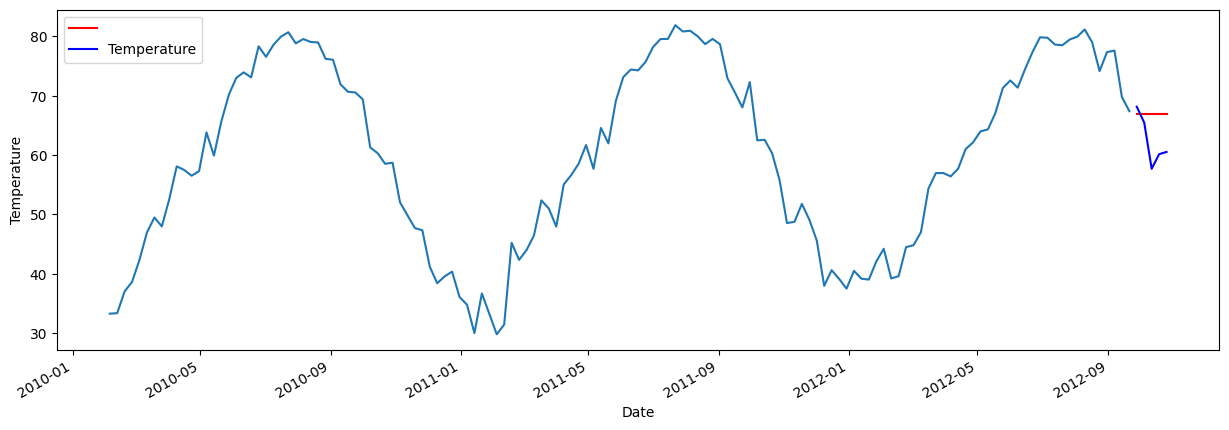

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
graph = sns.lineplot(x ='Date', y='Temperature', data= train)
pred1.plot(ax=ax ,color='red', legend=True)
test.plot(ax=ax, color='blue', legend=True)

- 주기성이나, 계절성이 있는 데이터기 때문에 이 부분을 학습을 놓칠 수 있다.

<Axes: xlabel='Date', ylabel='Temperature'>

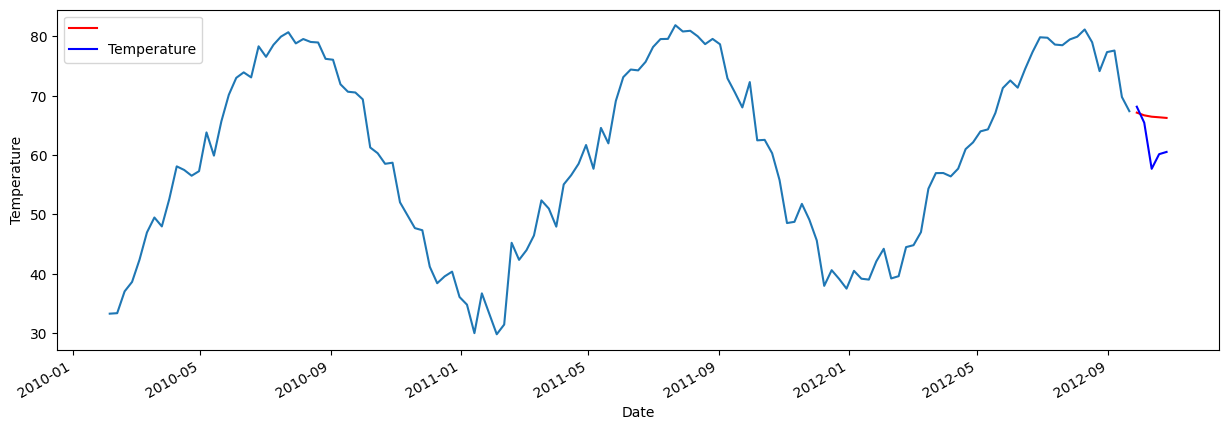

In [36]:
# Auto - Arima

auto_arima_model = pm.auto_arima(train, seasonal=True, m = 12)

pred2= auto_arima_model.predict(5)
pred2 = pd.Series(pred2, index= test.index)

#auto-ARIMA 학습 시각화
fig, ax = plt.subplots(figsize=(15,5))
graph = sns.lineplot(x ='Date', y='Temperature', data= train)
pred2.plot(ax=ax ,color='red', legend=True)
test.plot(ax=ax, color='blue', legend=True)

In [37]:
# auto_arima 모델요약

print(auto_arima_model.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  138
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -369.961
Date:                              Sun, 21 Jan 2024   AIC                            747.922
Time:                                      04:38:54   BIC                            759.631
Sample:                                  02-05-2010   HQIC                           752.681
                                       - 09-21-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4006      1.396      1.004      0.316      -1.335       4.136
ar.L1          0.97

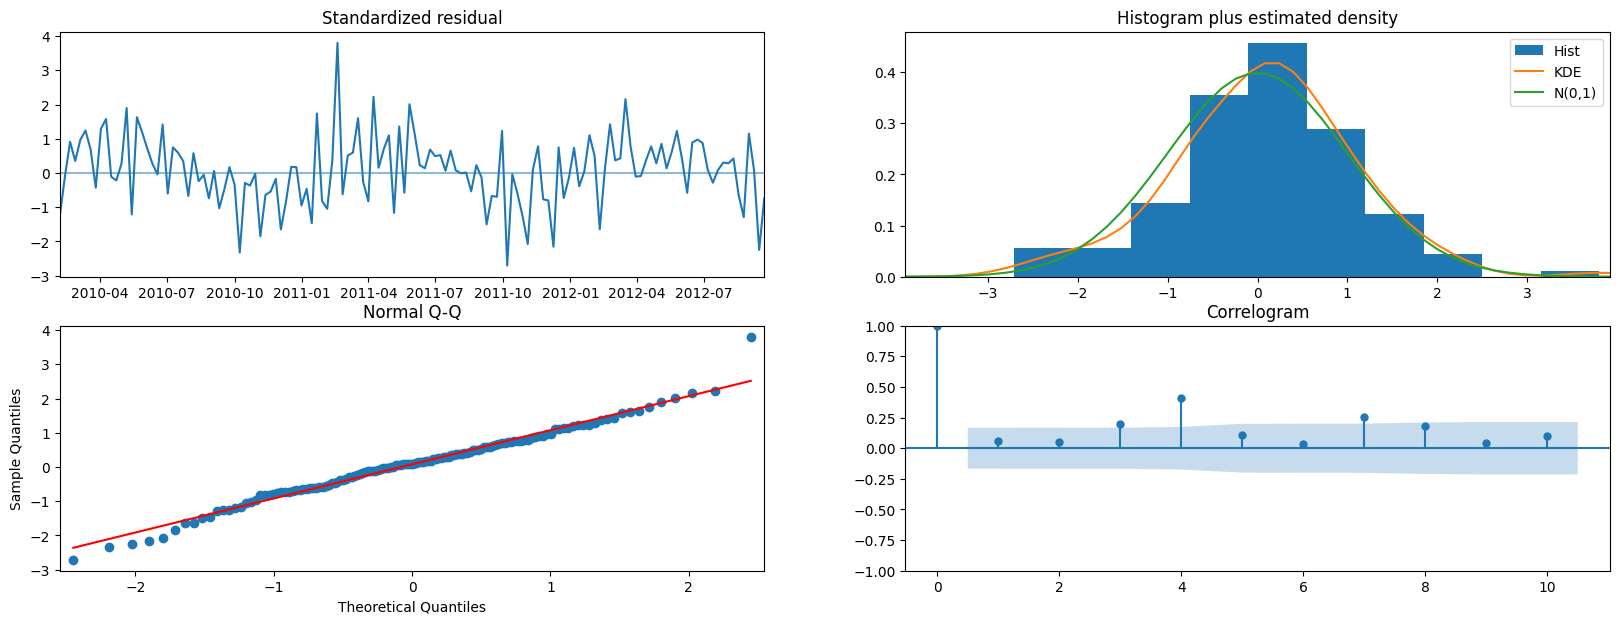

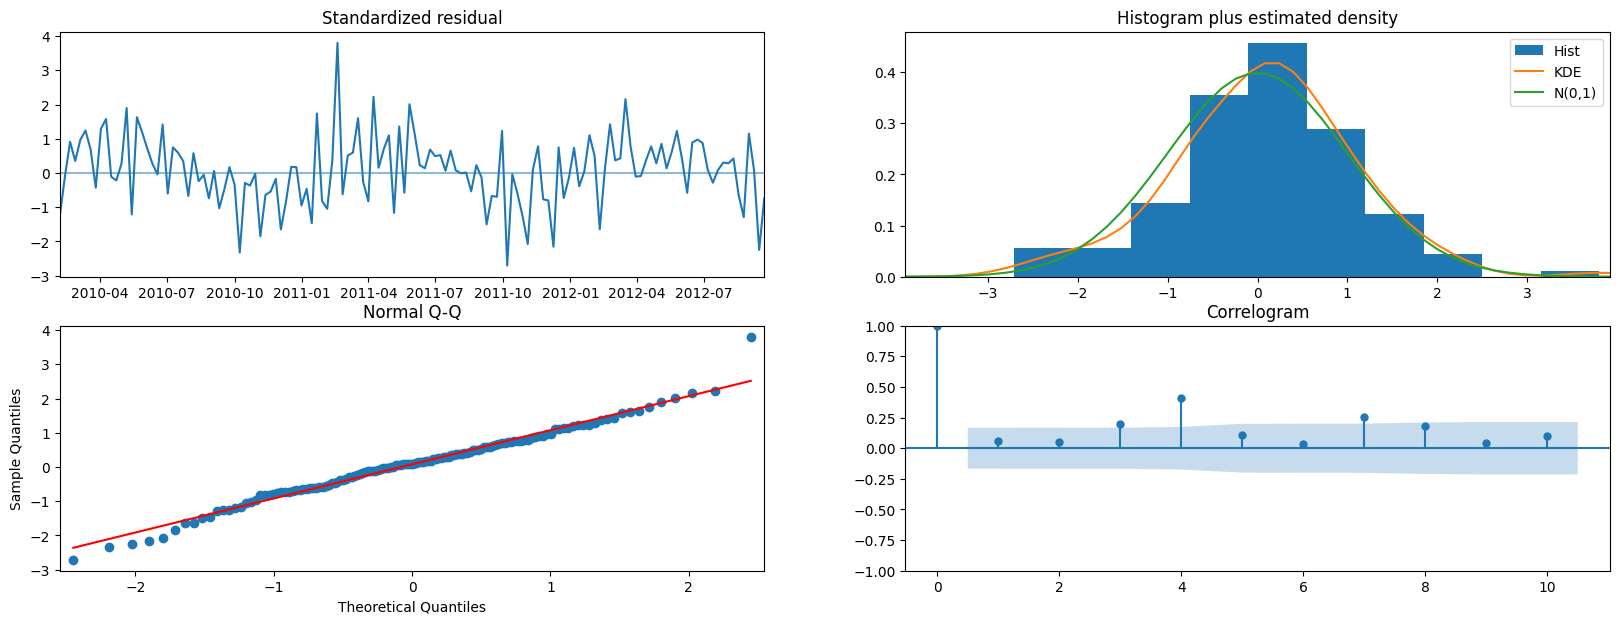

In [38]:
# 모델의 적합성 시각화
auto_arima_model.plot_diagnostics(figsize=(20,7))

## Prophet 시계열 분석

In [39]:
df_prophet= df[['Date','Temperature']]

In [40]:
df_prophet

,Date,Temperature
0,2010-02-05,42.31
330761,2010-02-05,27.19
330762,2010-02-05,27.19
330763,2010-02-05,27.19
330764,2010-02-05,27.19
...,...,...
128051,2012-10-26,46.97
128052,2012-10-26,46.97
128053,2012-10-26,46.97
390991,2012-10-26,41.80


In [41]:
def prepare_data(df, ds, y):
    df = df[[ds, y]]
    df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
    print('The series is ready for use.\n')
    return df

In [42]:
df5 = prepare_data(df_prophet, ds = 'Date', y = 'Temperature')
print(df5.head())
print('')
print('The length of your series is: ', df5.shape[0])

The series is ready for use.

               ds      y
0      2010-02-05  42.31
330761 2010-02-05  27.19
330762 2010-02-05  27.19
330763 2010-02-05  27.19
330764 2010-02-05  27.19

The length of your series is:  421570


In [43]:
df5['ds']=pd.to_datetime(df5['ds'])

df6=df5.set_index('ds')
df6=df6.resample('W').sum()
df6=df6.reset_index()


train = df6[:135]
test = df6[135:]

In [44]:
print(len(train))
print(len(test))
print(len(df6))

135
8
143


- 꼭 prophet은 ds와 y로 컬럼을 변경해야 한다.

In [45]:
prophet = Prophet(daily_seasonality=False,
                  growth='linear',
#                  changepoints=None,
                  n_changepoints=25,
                  changepoint_range=0.8,
                  yearly_seasonality='auto',
                  weekly_seasonality='auto',
                  holidays=None,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=0.05)
#                  mcmc_samples=0,
#                  interval_width=0.8,
#                  uncertainty_samples=1000,
#                  stan_backend=None)
prophet.fit(train)

# create a future data frame
future = prophet.make_future_dataframe(periods=10)
forecast = prophet.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsdwn31hx/5p_zp_vi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsdwn31hx/nt15p1lx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87218', 'data', 'file=/tmp/tmpsdwn31hx/5p_zp_vi.json', 'init=/tmp/tmpsdwn31hx/nt15p1lx.json', 'output', 'file=/tmp/tmpsdwn31hx/prophet_modelpzw4ry27/prophet_model-20240121043935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:39:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:39:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [46]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-07,166129.338214,93556.057035,109509.481123,166129.338214,166129.338214,-64561.537248,-64561.537248,-64561.537248,-64561.537248,-64561.537248,-64561.537248,0.0,0.0,0.0,101567.800965
1,2010-02-14,166214.025884,97018.684843,112459.944633,166214.025884,166214.025884,-61744.417212,-61744.417212,-61744.417212,-61744.417212,-61744.417212,-61744.417212,0.0,0.0,0.0,104469.608672
2,2010-02-21,166298.713554,101450.720252,117761.913518,166298.713554,166298.713554,-56686.430377,-56686.430377,-56686.430377,-56686.430377,-56686.430377,-56686.430377,0.0,0.0,0.0,109612.283177
3,2010-02-28,166383.401224,109781.439072,126317.373938,166383.401224,166383.401224,-48262.516551,-48262.516551,-48262.516551,-48262.516551,-48262.516551,-48262.516551,0.0,0.0,0.0,118120.884674
4,2010-03-07,166468.088895,120614.452453,136403.614498,166468.088895,166468.088895,-37678.343369,-37678.343369,-37678.343369,-37678.343369,-37678.343369,-37678.343369,0.0,0.0,0.0,128789.745526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2012-09-08,175102.117926,213872.731053,230192.808522,175102.117926,175102.117926,46863.713995,46863.713995,46863.713995,46863.713995,46863.713995,46863.713995,0.0,0.0,0.0,221965.831921
141,2012-09-09,175085.902594,212320.987154,229182.252727,175085.902594,175085.902594,46081.198237,46081.198237,46081.198237,46081.198237,46081.198237,46081.198237,0.0,0.0,0.0,221167.100830
142,2012-09-10,175069.687261,212395.819762,228478.978126,175069.687261,175069.687261,45286.370922,45286.370922,45286.370922,45286.370922,45286.370922,45286.370922,0.0,0.0,0.0,220356.058183
143,2012-09-11,175053.471929,211198.863541,227088.769967,175053.463840,175053.895601,44479.681379,44479.681379,44479.681379,44479.681379,44479.681379,44479.681379,0.0,0.0,0.0,219533.153309


Printing outputs from Prophet prediction...
           ds           yhat     yhat_lower     yhat_upper
0 2010-02-07  101567.800965   93556.057035  109509.481123
1 2010-02-14  104469.608672   97018.684843  112459.944633
2 2010-02-21  109612.283177  101450.720252  117761.913518
3 2010-02-28  118120.884674  109781.439072  126317.373938
4 2010-03-07  128789.745526  120614.452453  136403.614498


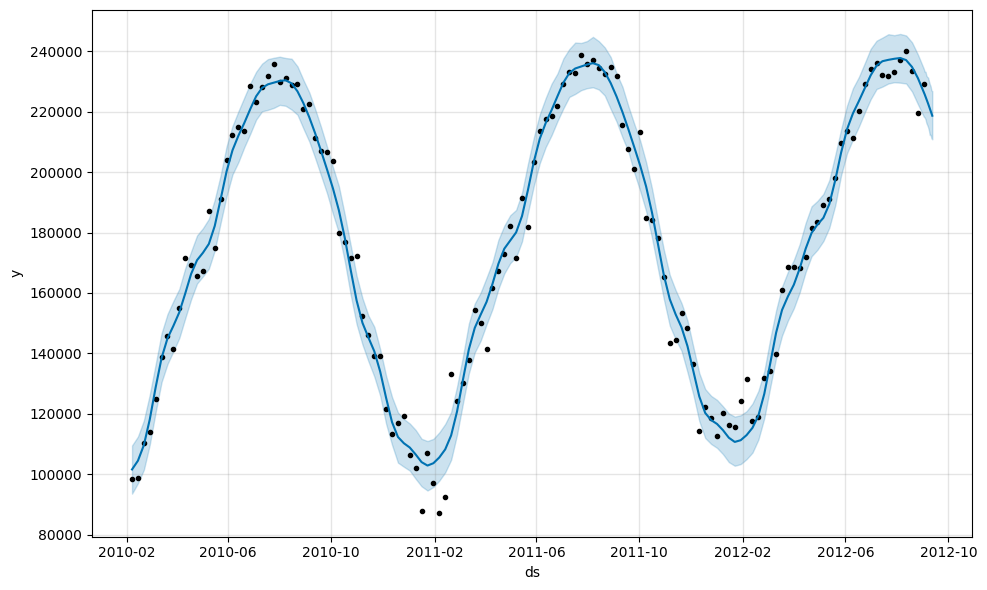

In [47]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [48]:
#y_true .rt\
print('Length of forcast series, train series, and original series: ', len(forecast), len(train), len(df6))
print(' ')
y_true= test['y'].values
y_pred = forecast['yhat'][-len(y_true):].values
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Length of forcast series, train series, and original series:  145 135 143
 
Mean Absolute Error: 27715.958


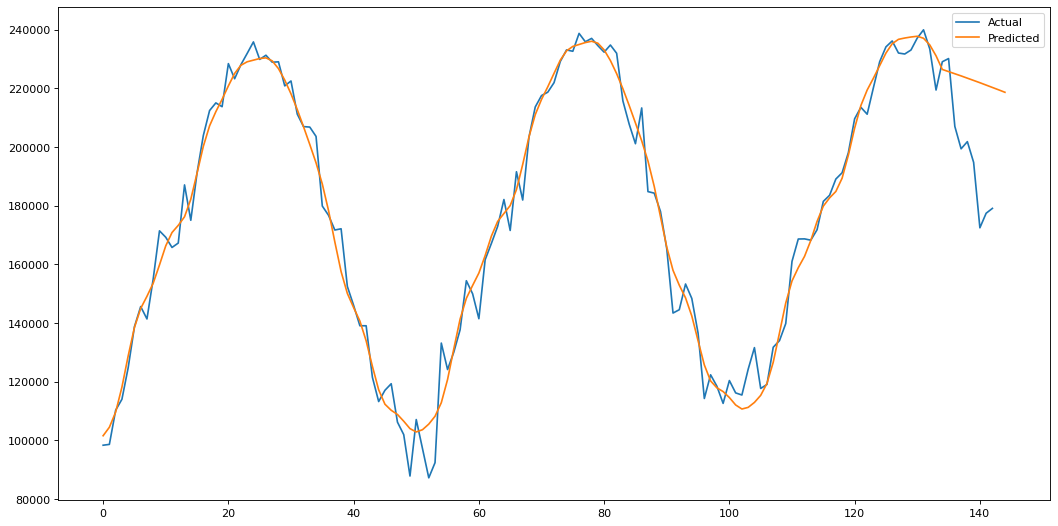

In [49]:
# plot expected vs actual
import matplotlib.pyplot as pltt
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80)

pltt.plot(df6['y'].values, label='Actual')
pltt.plot(forecast['yhat'].values, label='Predicted')
pltt.legend()
pltt.show()

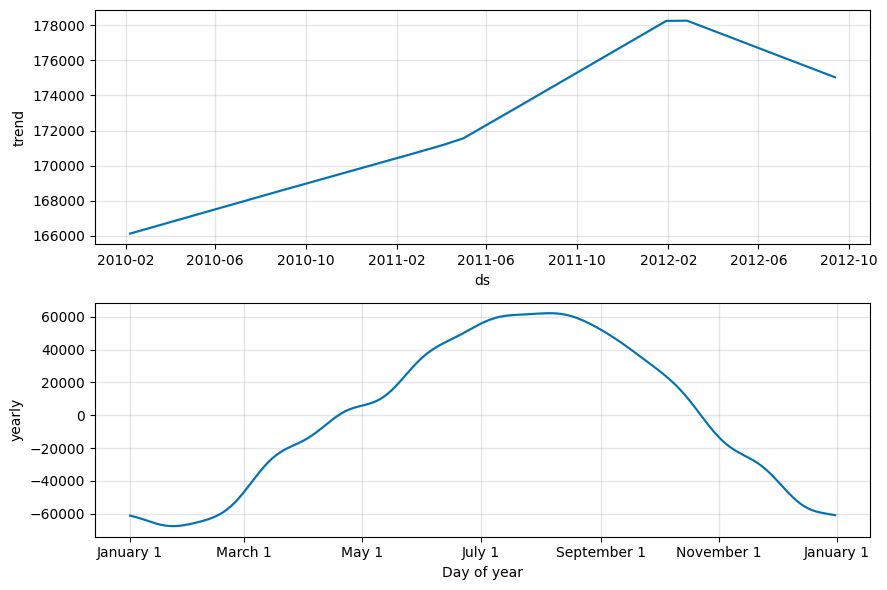

In [50]:
fig2 = prophet.plot_components(forecast)
plt.show()